In [1]:
import os,sys,signal
import math

import pickle
import numpy as np                                       # fast vectors and matrices
import matplotlib.pyplot as plt                          # plotting
sys.path.insert(0, '../')

import musicnet

from time import time

from sklearn.metrics import average_precision_score

os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES']='0'

import torch
from torch.nn.functional import conv1d, mse_loss
import torch.nn.functional as F
import torch.nn as nn

from nnAudio import Spectrogram

if torch.cuda.is_available():
    device = "cuda:0"
#     torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = "cpu"

In [2]:
# Network Parameters
epochs = 35
train_size = 100000
test_size = 50000
epsilon = 1e-5
fs = 44100

lr = 1e-6
momentum = .95

pitch_shift = 0
jitter = 0.
num_workers = 10
sequence = 1

# lvl1 convolutions are shared between regions
m = 128
k = 512              # lvl1 nodes
n_fft = 4096              # lvl1 receptive field
window = 16384 # total number of audio samples?
stride = 512
batch_size = 100
freq_bins = 2049

regions = 1 + (window)//stride

def worker_init(args):
    signal.signal(signal.SIGINT, signal.SIG_IGN) # ignore signals so parent can handle them
    np.random.seed(os.getpid() ^ int(time())) # approximately random seed for workers
kwargs = {'num_workers': num_workers, 'pin_memory': True, 'worker_init_fn': worker_init}

In [3]:
# function for returning scientific notation in a plot
def fmt(x, pos):
    a, b = '{:.0e}'.format(x).split('e')
    b = int(b)
    return fr'${a} \times 10^{{{b}}}$'

In [4]:
result_dict = {'loss_history_train': [],
               'avgp_history_train': [],
               'loss_history_test': [],
               'avgp_history_test': [],
               "Mir_Eval": [],
               'parameters': {}}

result_dict['parameters']['train_size'] = train_size
result_dict['parameters']['test_size'] = test_size
result_dict['parameters']['lr'] = lr
result_dict['parameters']['pitch_shift'] = pitch_shift
result_dict['parameters']['jitter'] = jitter
result_dict['parameters']['window'] = window

# Preparing Dataset

In [5]:
start = time()
root = './data/'
train_set = musicnet.MusicNet(root=root, epoch_size=train_size,sequence=sequence
                              , train=True, download=True, refresh_cache=False, 
                              window=window, mmap=False, pitch_shift=pitch_shift, jitter=jitter)
test_set = musicnet.MusicNet(root=root, train=False, download=True,sequence=sequence
                             , refresh_cache=False, window=window, epoch_size=test_size, mmap=False)
print("Data loaded, time used = {:2.2f} seconds".format(time()-start))

train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,**kwargs)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,**kwargs)

Data loaded, time used = 27.63 seconds


# Defining Models

In [6]:
Loss = torch.nn.BCELoss()
def L(yhatvar,y):
    return Loss(yhatvar,y) * 128/2

In [7]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # Getting Mel Spectrogram on the fly

        self.STFT_layer = Spectrogram.STFT(sr=44100, n_fft=n_fft, freq_bins=freq_bins, fmin=50, fmax=6000,
                                           freq_scale='linear', pad_mode='constant', center=True,
                                           trainable=True)
        self.n_bins = freq_bins
        # Creating Layers
        self.linear = torch.nn.Linear(self.n_bins*regions, m, bias=False)
#         torch.nn.init.constant_(self.linear.weight, 0) # initialize
        
    def forward(self,x):
        z = self.STFT_layer(x)
        y = self.linear((torch.log(z+epsilon)).view(x.data.size()[0], self.n_bins*regions))
        return torch.sigmoid(y)
    

In [8]:
model = Model()
model.to(device)

sampling rate = 44100. Please make sure the sampling rate is correct in order to get a valid freq range
STFT kernels created, time used = 8.2868 seconds


Model(
  (STFT_layer): STFT()
  (linear): Linear(in_features=67617, out_features=128, bias=False)
)

In [9]:
original_wsin = model.STFT_layer.wsin.cpu().detach().numpy()
original_wcos = model.STFT_layer.wcos.cpu().detach().numpy()

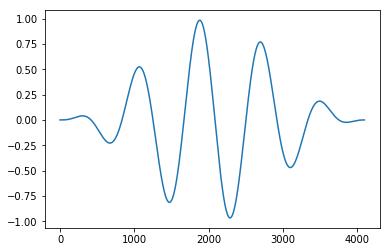

In [10]:
plt.plot(model.STFT_layer.wsin.cpu().detach().numpy()[1][0])

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [12]:
try:
    with train_set, test_set:
        print("epoch\ttrain loss\ttest loss\ttrain avg\ttest avg\ttime\tutime")
        for e in range(epochs):
            yground = torch.Tensor(batch_size*len(train_loader), m) # what not do this together with loss
            yhat = torch.Tensor(batch_size*len(train_loader), m)
            avgp, loss_e = 0.,0
            t = time()
            for i, (x,y) in enumerate(train_loader):
                print(f"training {i}/{len(train_loader)} batches", end = '\r')
                optimizer.zero_grad()

                # making x and y into pytorch dealable format
                x = x.to(device, non_blocking=True)
                y = y.to(device, non_blocking=True)
                yhatvar = model(x)
                newwsin = model.STFT_layer.wsin
                loss = L(yhatvar,y)
                loss.backward()
                loss_e += loss.item() #getting the number

                yground[i*batch_size:(i+1)*batch_size] = y.data
                yhat[i*batch_size:(i+1)*batch_size] = yhatvar.data

                optimizer.step()
            avgp = average_precision_score(yground.cpu().flatten(),yhat.cpu().flatten())  

            result_dict['loss_history_train'].append(loss_e/len(train_loader))
            result_dict['avgp_history_train'].append(avgp)   
            t1 = time()
            avgp, loss_e = 0.,0.           
#             optimizer.swap_swa_sgd() # change to average weight

            # For testing
            yground = torch.Tensor(batch_size*len(test_loader), m) # what not do this together with loss
            yhat = torch.Tensor(batch_size*len(test_loader), m)

            for i, (x_test,y_test) in enumerate(test_loader):
                print(f"testing {i}/{len(test_loader)} batches", end = '\r')
                x_test = x_test.to(device)
                y_test = y_test.to(device)
                yhatvar = model(x_test)
                loss_e += L(yhatvar, y_test).item() #getting the number

                yground[i*batch_size:(i+1)*batch_size] = y_test.data
                yhat[i*batch_size:(i+1)*batch_size] = yhatvar.data
            avgp = average_precision_score(yground.cpu().flatten(),yhat.cpu().flatten())
            result_dict['loss_history_test'].append(loss_e/len(test_loader))
            result_dict['avgp_history_test'].append(avgp)
            print('{}\t{:2f}\t{:2f}\t{:2f}\t{:2f}\t{:2.1f}\t{:2.1f}'.\
                  format(e,
                         result_dict['loss_history_train'][-1],result_dict['loss_history_test'][-1],
                         result_dict['avgp_history_train'][-1],result_dict['avgp_history_test'][-1],
                         time()-t, time()-t1))

except KeyboardInterrupt:
    print('Graceful Exit')
else:
    print("Finsihed")

epoch	train loss	test loss	train avg	test avg	time	utime
0	5.665285	3.412580	0.141287	0.370724	118.4	17.4
1	3.821137	2.830759	0.473492	0.497170	118.4	17.3
Graceful Exit000 batches


In [35]:
trained_wsin = model.STFT_layer.wsin.cpu().detach().numpy()
trained_wcos = model.STFT_layer.wcos.cpu().detach().numpy()

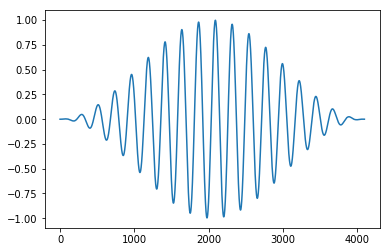

In [32]:
plt.plot(model.STFT_layer.wsin.cpu().detach().numpy()[50][0])

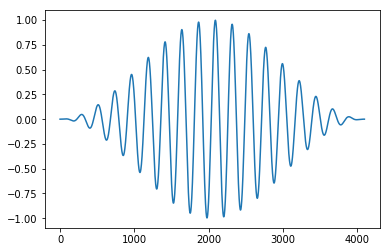

In [48]:
plt.plot(original_wsin[50][0])

array([-2.98885483e-04, -3.17253784e-04, -3.04975052e-04, ...,
       -1.32863293e-04, -1.09403416e-04, -9.36876531e-05], dtype=float32)

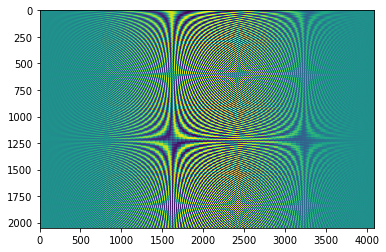

In [28]:
plt.imshow(model.STFT_layer.wsin.cpu().detach().numpy().reshape(2049,4096), aspect='auto')

In [16]:
mel_layer = Spectrogram.MelSpectrogram(sr=44100, fmin=55, fmax=6000)
STFT_layer = Spectrogram.STFT(sr=44100, n_fft=2048, fmin=50, fmax=6000, freq_scale='log', pad_mode='constant')

STFT filter created, time used = 0.2024 seconds
Mel filter created, time used = 0.0031 seconds
sampling rate = 44100. Please make sure the sampling rate is correct in order to get a valid freq range
STFT kernels created, time used = 0.1919 seconds


In [17]:
mel_layer(x)[0].cpu().numpy().shape

(128, 33)

Text(0.5, 1.0, 'Melspectrogram')

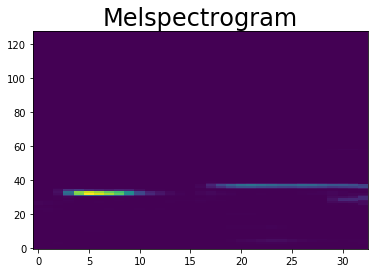

In [18]:
plt.imshow(mel_layer(x)[0].cpu().numpy(), aspect='auto', origin='lower')
plt.title("Melspectrogram", size=24)

Text(0.5, 1.0, 'STFT Log')

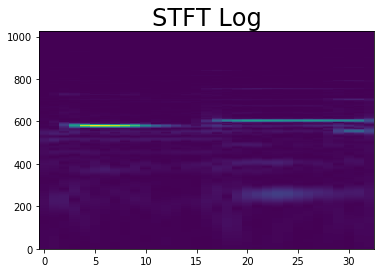

In [19]:
plt.imshow(STFT_layer(x)[0].cpu().numpy(), aspect='auto', origin='lower')
plt.title("STFT Log", size=24)

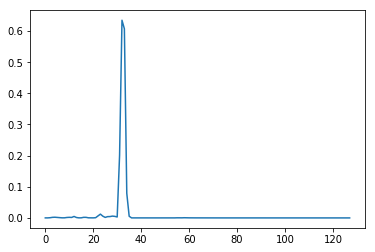

In [20]:
plt.plot(mel_layer(x)[0].cpu().numpy()[:,10])

# CQT

In [21]:
from librosa import cqt

In [22]:
lib_result = abs(cqt(x[0].cpu().numpy(), sr=44100, fmin=55, n_bins=84*4, bins_per_octave=48, pad_mode='constant'))

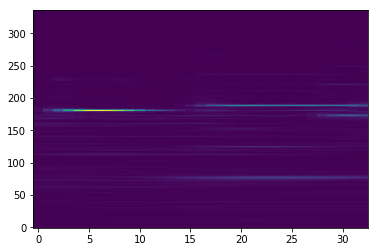

In [23]:
plt.imshow(lib_result, aspect='auto', origin='lower')

In [24]:
torch_result = model.cqt_layer(x)[0].cpu().numpy()
plt.imshow(torch_result, aspect='auto', origin='lower')

AttributeError: 'Model' object has no attribute 'cqt_layer'

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16,5))
ax[0].plot(lib_result[:, 10])
ax[1].plot(torch_result[:, 10])

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = SWA(base_opt, swa_start=0, swa_freq=1, swa_lr=0.000001)

try:
    with train_set, test_set:
        print("epoch\ttrain loss\ttest loss\ttrain avg\ttest avg\ttime\tutime")
        yground = torch.Tensor(batch_size*len(train_loader), m) # what not do this together with loss
        yhat = torch.Tensor(batch_size*len(train_loader), m)
        avgp, loss_e = 0.,0
        t = time()
        for i, (x,y) in enumerate(train_loader):
            x = x.to(device)
            break
except:
    pass